## Задача 2. Сравнение методов классификации

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random
import warnings

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore') 
pd.set_option('display.precision', 4)
random.seed(19)
np.set_printoptions(precision=4)
np.random.seed(19)

[x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.

In [43]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array

KNN

In [44]:
class MyKnn(ClassifierMixin):
    def __init__(self, n_neighbors=3):
        self._n_neighbors = n_neighbors
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self._X = X
        self._y = y
        return self

    def predict(self, X):
        X = check_array(X)
        predictions = []
        for row in X:
            distances = self.calculate_distances(row)
            distances.sort(key=lambda tupl: tupl[1])
            neighbors_indx = self.get_neighbors(distances)
            label = self.get_popular_label(neighbors_indx)
            predictions.append(label)
        return predictions

    def calculate_distances(self, row):
        distances = list()
        length = len(row)
        for i, _row in enumerate(self._X):
            dist = 0.0
            for k in range(length - 1):
                dist += ((row[k] - _row[k])**2)
            dist = np.sqrt(dist)
            distances.append((i, dist))
        return distances

    def get_neighbors(self, distances):
        neighbors_indx = list()
        for i in range(self._n_neighbors):
            neighbors_indx.append(distances[i][0])
        return neighbors_indx
    
    def get_popular_label(self, neighbors):
        labels = []
        for i in neighbors:
            labels.append(self._y[i])
        label = max(set(labels), key=labels.count)
        return label

    def get_params(self, deep=True):
        return {"n_neighbors": self._n_neighbors}
    
    def set_params(self, **parameters):
        for param, value in parameters.items():
            setattr(self, param, value)
        return self

[x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти 

[x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).

In [45]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [46]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [47]:
df["target"].value_counts()

1    526
0    499
Name: target, dtype: int64

[x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.

In [48]:
df["sex"].value_counts()

1    713
0    312
Name: sex, dtype: int64

In [49]:
df.groupby(['sex', 'target'])['target'].count() 

sex  target
0    0          86
     1         226
1    0         413
     1         300
Name: target, dtype: int64

<AxesSubplot: xlabel='sex', ylabel='count'>

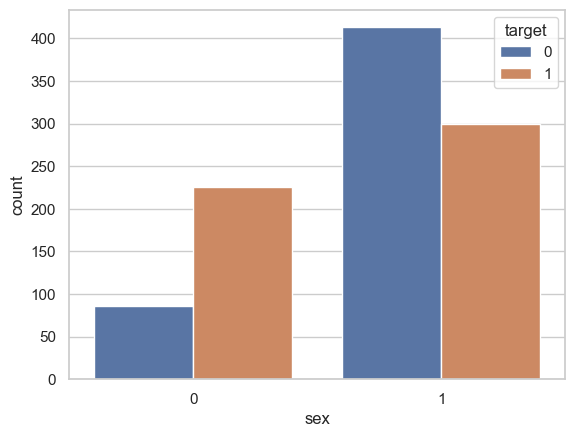

In [50]:
sns.countplot(x='sex', hue='target', data=df)

<AxesSubplot: xlabel='sex', ylabel='target'>

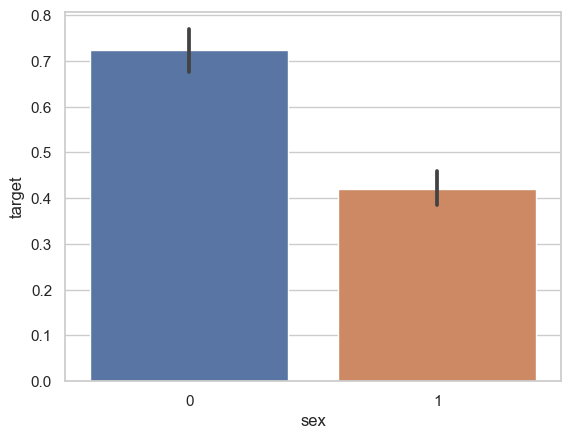

In [51]:
sns.barplot(x='sex', y='target', data=df)

Несмотря на то, что в данном наборе мужчин в два раза больше женщин, последние имеют большую вероятность иметь заболевание сердца.

In [52]:
df['age'].describe()

count    1025.0000
mean       54.4341
std         9.0723
min        29.0000
25%        48.0000
50%        56.0000
75%        61.0000
max        77.0000
Name: age, dtype: float64

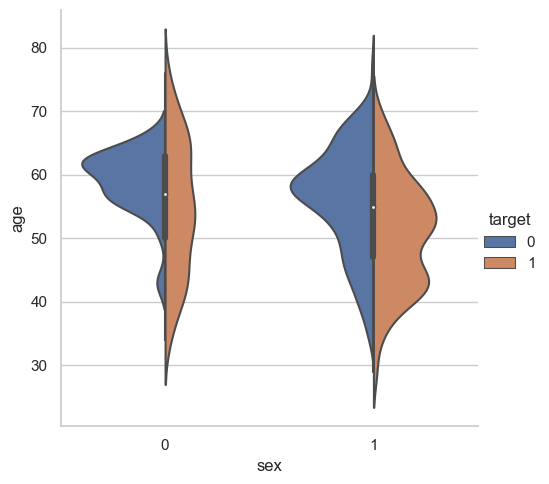

In [53]:
sns.catplot(data=df, kind="violin", x="sex", y="age", hue="target", split=True)

* Среди пациентов нет моложе 29 лет
* У женщин почти нет зависимости от возраста
* Среди мужчин, диагноз имею чуть те у кого возраст 40-45 и 50-60

In [54]:
df["cp"].value_counts()

0    497
2    284
1    167
3     77
Name: cp, dtype: int64

<AxesSubplot: xlabel='cp', ylabel='count'>

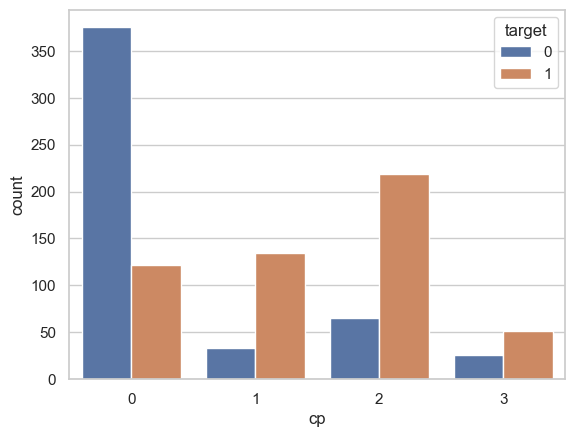

In [55]:
sns.countplot(x='cp', hue='target', data=df)

<AxesSubplot: xlabel='cp', ylabel='target'>

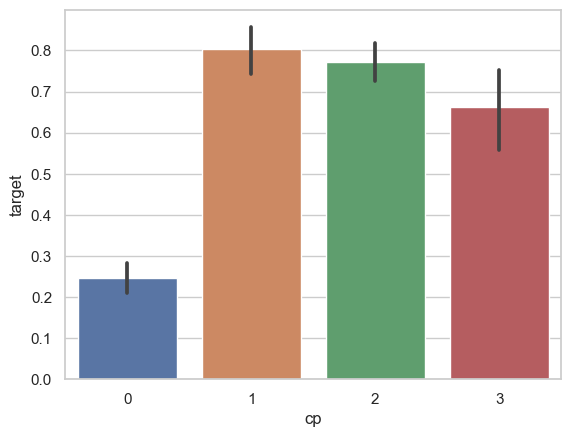

In [56]:
sns.barplot(x='cp', y='target', data=df)

В основном у пациентов с типом грудной боли 0 мало наблюдается заболевание сердца

[x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).

In [57]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])

df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,0,0,0,0,0,0,1,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,0,0,0,0,0,1,1,0,0
2,70,1,145,174,0,1,125,1,2.6,0,...,0,0,0,0,0,0,1,1,0,0
3,61,1,148,203,0,1,161,0,0.0,1,...,0,0,0,0,0,0,1,0,0,1
4,62,0,138,294,1,1,106,0,1.9,3,...,0,0,0,0,0,1,0,0,1,0


[x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.

#### Разбиение данных на тестовую и обучающую выборки

In [58]:
from sklearn.model_selection import train_test_split

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Масштабирование данных

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

#### Подбор наилучшего подмножества признаков

In [60]:
from sklearn.feature_selection import RFECV
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifierCV

rfecv = RFECV(estimator=RidgeClassifierCV())
rfecv.fit(X_train_scaled, y_train)

print(f"Optimal numbers of feature: {rfecv.n_features_}")
features = list(X_train_scaled.columns[rfecv.support_])
print(f"Selected features: {features}")

Optimal numbers of feature: 15
Selected features: ['sex', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'thal_0', 'thal_2', 'thal_3', 'slope_1']


In [61]:
X_train_scaled = X_train_scaled[features]
X_test_scaled = X_test_scaled[features]

#### Подбор гиперпараметров

In [62]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(5, shuffle=True, random_state=19)

MyKNN

In [63]:
neighbors_grid = [3,5,7,9,11]

searcher_myknn = GridSearchCV(MyKnn(), [{"neighbors": neighbors_grid}], cv=cv)
searcher_myknn.fit(X_train_scaled, y_train)

optimal_n_neighbors = searcher_myknn.best_params_["neighbors"]
print(f"Neighbors: {optimal_n_neighbors}")

Neighbors: 3


[x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).

KNN (библиотечная)

In [64]:
from sklearn.neighbors import KNeighborsClassifier

searcher_knn = GridSearchCV(KNeighborsClassifier(), [{"n_neighbors": neighbors_grid}], cv=cv)
searcher_knn.fit(X_train_scaled, y_train)

optimal_n_neighbors_knn = searcher_knn.best_params_["n_neighbors"]
print(f"Neighbors: {optimal_n_neighbors_knn}")

Neighbors: 3


SVM (библиотечная)

In [65]:
from sklearn.svm import SVC

kernel_grid = ["linear", "rbf"]
c_grid = [0.1, 0.25, 0.5, 0.75, 1]
gamma_grid = ["scale", "auto"]

searcher_svm = GridSearchCV(SVC(random_state=19), [{"kernel": kernel_grid, "C": c_grid, "gamma": gamma_grid}], cv=cv)
searcher_svm.fit(X_train_scaled, y_train)

optimal_kernel = searcher_svm.best_params_["kernel"]
print(f"Kernel: {optimal_kernel}")
optimal_c = searcher_svm.best_params_["C"]
print(f"C: {optimal_c}")
optimal_gamma = searcher_svm.best_params_["gamma"]
print(f"Gamma: {optimal_gamma}")

Kernel: rbf
C: 1
Gamma: scale


[x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.

In [66]:
from sklearn.metrics import accuracy_score

accuracies = {}

MyKNN

In [67]:
classifier = MyKnn(optimal_n_neighbors)
classifier.fit(X_train_scaled, y_train)

y_test_myknn = classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_test_myknn)
accuracies['MyKNN'] = accuracy
print(f"Test accuracy of MyKNN: {accuracy}")

Test accuracy of MyKNN: 0.9058441558441559


KNN (библиотечная)

In [68]:
classifier_knn = KNeighborsClassifier(optimal_n_neighbors_knn)
classifier_knn.fit(X_train_scaled, y_train)

y_test_knn = classifier_knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_test_knn)
accuracies['KNN'] = accuracy
print(f"Test accuracy of KNN: {accuracy}")

Test accuracy of KNN: 0.9285714285714286


SVM (библиотечная)

In [69]:
classifier_svm = SVC(kernel=optimal_kernel, C=optimal_c, gamma=optimal_gamma, random_state=19)
classifier_svm.fit(X_train_scaled, y_train)

y_test_svm = classifier_svm.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_test_svm)
accuracies['SVM'] = accuracy
print(f"Test accuracy of SVM: {accuracy}")

Test accuracy of SVM: 0.8733766233766234


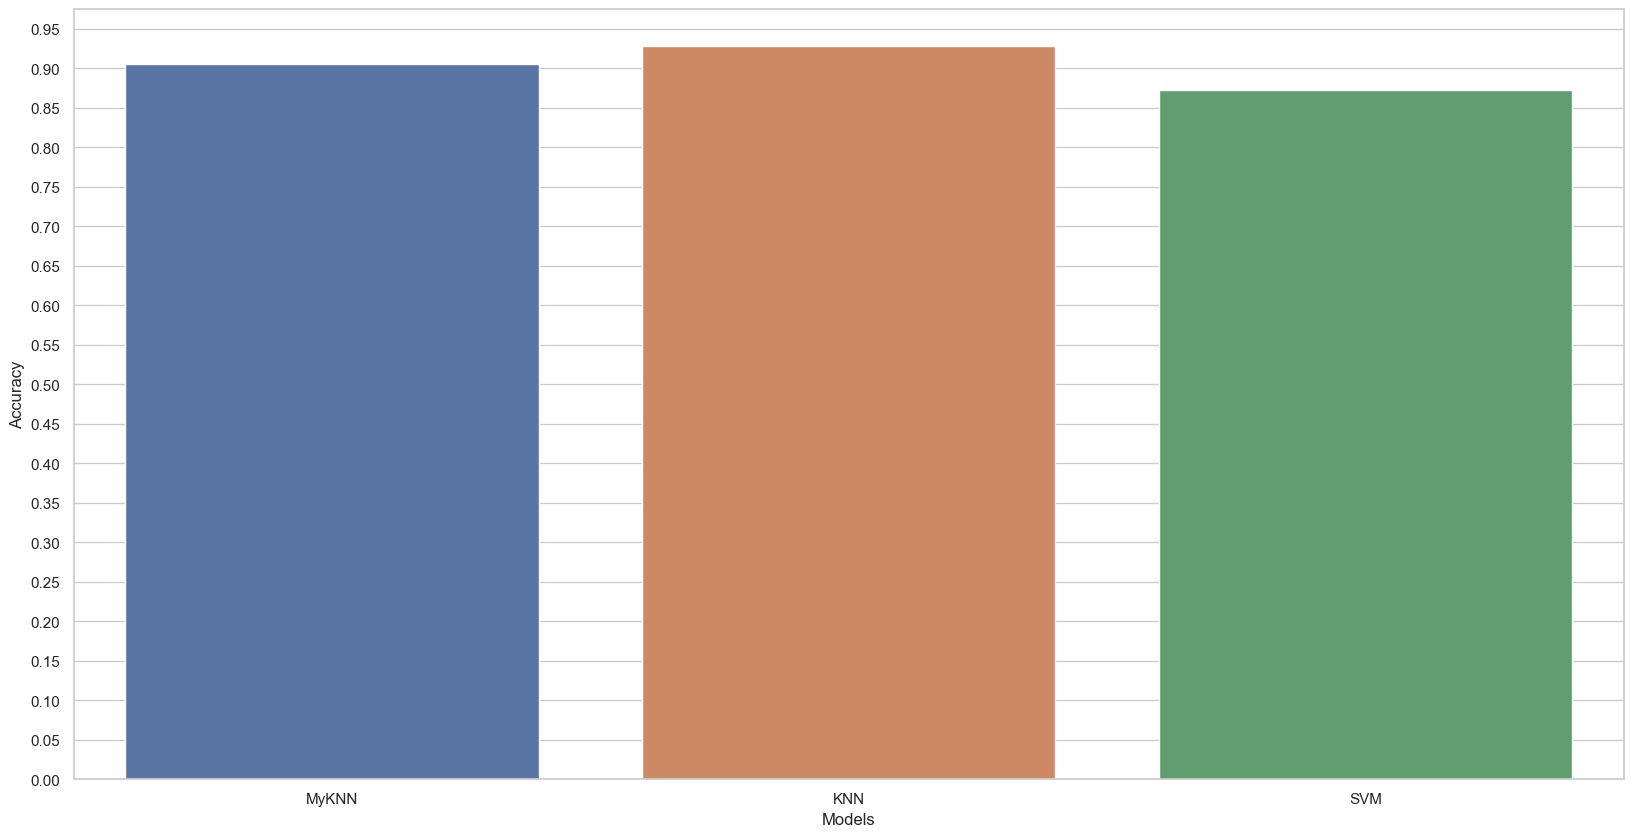

In [70]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

In [71]:
from sklearn.metrics import confusion_matrix

my_knn_cm = confusion_matrix(y_test, y_test_myknn)
knn_cm = confusion_matrix(y_test, y_test_knn)
svm_cm = confusion_matrix(y_test, y_test_svm)

<AxesSubplot: title={'center': 'SVM Confusion Matrix'}>

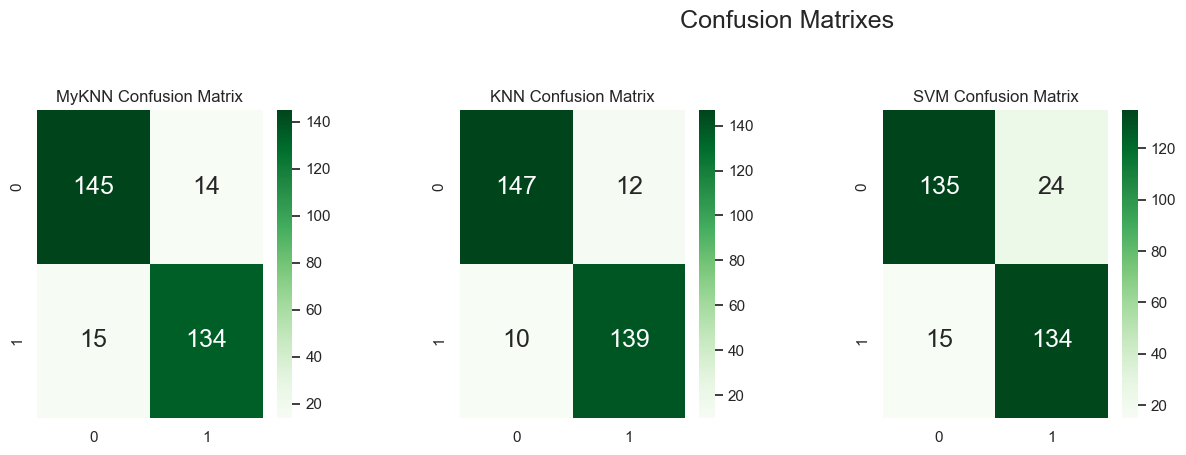

In [72]:
plt.figure(figsize=(20, 10))
plt.suptitle("Confusion Matrixes", fontsize=18)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2, 4, 1)
plt.title("MyKNN Confusion Matrix")
sns.heatmap(my_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 2)
plt.title("KNN Confusion Matrix")
sns.heatmap(knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 3)
plt.title("SVM Confusion Matrix")
sns.heatmap(svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})
